### Option 3: Machine Learning for Fraud, Waste, and Abuse (FWA) Detection using Isolation Forest and Anomaly Scores
> **IDEA** - We can use an Isolation Forest to detect suspicious claims, then visualize the anomaly scores.
In this analysis, we leverage machine learning techniques to identify potentially suspicious claims that may indicate fraud or abuse within healthcare data.

> **Isolation Forest Overview:**  
*Isolation Forest is an anomaly detection algorithm that isolates outliers by randomly partitioning data points in a feature space. Unlike traditional methods, it does not rely on distance or density measures but instead focuses on how quickly a data point can be separated from the rest. Points that require fewer splits to isolate are considered anomalies. This makes Isolation Forest especially effective for detecting unusual claims that deviate significantly from normal patterns.*
---

**Notebook: healthcare_fwa_opt2_analysis.ipnyb**
> **NOTE**
Below approach is an extension of the approach taken on Notebook: **healthcare_fwa_analysis.ipnyb**, and we are trying to incorporate additional outliers for Unsupervised Anomaly Detection 

#### Solution Overview

1. **Feature Engineering**:
   - We extract relevant features from claims data, such as:
     - **Claim Amount (`AMOUNT`)**: The monetary value of each claim.
     - **Days Since Last Claim (`DAYS_SINCE_LAST_CLAIM`)**: Time interval between consecutive claims per patient.
     - **Number of Claims per Provider (`NUM_CLAIMS_PER_PROVIDER`)**: Claim volume associated with each healthcare provider.
   
2. **Unsupervised Anomaly Detection**:
   - Since labeled data indicating fraudulent claims may not be available, we employ **unsupervised models**.
   - Specifically, we use the **Isolation Forest** algorithm, which is designed to identify anomalies (outliers) that deviate from normal claim patterns.

---

#### How the Model Works

- **Isolation Forest** constructs a series of binary trees by randomly partitioning the feature space.
- **Anomalies** tend to be isolated early in the tree construction because they are different from the majority of data points.
- The model produces an **anomaly score** for each claim:
  - Values closer to **-1** indicate high anomaly likelihood.
  - Values closer to **1** suggest normal claims.

---

#### Implementation Steps

##### 1. **Train the Model**:
   - Fit the Isolation Forest on the selected features.
   - The model learns the typical patterns of claims.

##### 2. **Compute Anomaly Scores**:
   - Each claim gets a score indicating how unusual it is.
   
##### 3. **Identify Suspicious Claims**:
   - Set a threshold (e.g., the bottom 2%) to classify claims as suspicious.

##### 4. **Visualization & Analysis**:
   - Visualize the distribution of anomaly scores.
   - Compare claim amounts for suspicious vs. normal claims.
   - Use feature importance and model explainability tools (e.g., SHAP) to understand drivers of anomalies.

---


## Feature Engineering

Feature engineering is a vital step in developing effective machine learning models for detecting healthcare fraud, waste, and abuse (FWA). Raw healthcare claims data, while rich in information, often contains noise and redundant information. By transforming this raw data into meaningful, informative features, we enable models to better recognize intricate fraud patterns and suspicious behaviors.

### Anomaly Detection Features

This approach involves creating relevant features from healthcare claims data to identify suspicious or anomalous claims using machine learning techniques:

- **Numerical Features:** Includes claim amount, units, and claim frequency metrics such as claims per provider or patient, which help highlight outliers in financial and utilization patterns.
- **Categorical Variables Encoding:** Encodes categorical identifiers like provider IDs and patient IDs to enable machine learning models to interpret these features effectively.
- **Preparation for Anomaly Detection:** These engineered features serve as input for algorithms like Isolation Forest or Local Outlier Factor, which analyze the data to detect claims that deviate significantly from normal patterns, flagging potential fraud or abuse.

This systematic feature engineering enhances the accuracy of anomaly detection models, enabling more effective identification of suspicious claims for further investigation.



## 1. Initializing Python Modules

In [1]:
pip install pandas matplotlib seaborn plotly fhirclient scikit-learn networkx nbformat

Note: you may need to restart the kernel to use updated packages.


## 2. Data Loading 

>**Assumptions**
For now we are assuming the data is stored within the root folder of this solution.

The datasets are stored in the following directory structure:

```
data/
└── sample_data/
    └── csv/
        └── [county-specific folders]/
            └── *.csv
```

and we are loading the data from the specific folder by using a variable called **data_location** below. 
This value drives the folder from which the data is loaded for analysis. 

In [2]:
import os
import pandas as pd

# Get current directory
current_path = os.getcwd()
print("Current Directory:", current_path)

# Determine parent directory (assuming your data folder is one level up)
parent_dir = os.path.dirname(current_path)

# Set your dataset location (e.g., 'galway', 'cork', 'dublin', 'limerick')
data_location = "galway"  # Change as needed

# Construct the path to your CSV folder
data_folder_path = os.path.join(parent_dir, 'data', 'sample_data', 'csv', data_location)
common_folder_path = os.path.join(parent_dir, 'data', 'sample_data', 'csv', 'common')

print("CSV Files Path:", data_folder_path)
print("Common Files Path:", common_folder_path)

#data/sample_data/csv/allergies.csv
# Example: Load patient, claims, provider CSV files
patients_df = pd.read_csv(os.path.join(data_folder_path, 'patients.csv'))
claims_df = pd.read_csv(os.path.join(data_folder_path, 'claims.csv'))
transactions_df = pd.read_csv(os.path.join(data_folder_path, 'claims_transactions.csv'))
providers_df = pd.read_csv(os.path.join(data_folder_path, 'providers.csv'))
zipcodes_df = pd.read_csv(os.path.join(common_folder_path, 'zipcodes.csv'))

print("\nPatients DataFrame columns: \n ---------------------------------------\n", patients_df.columns)
print("\nClaims DataFrame columns: \n ---------------------------------------\n", claims_df.columns)
print("\nTransactions DataFrame columns: \n ---------------------------------\n", transactions_df.columns)
print("\nProviders DataFrame columns: \n ---------------------------------------\n", providers_df.columns)
print("\nZipCode DataFrame columns: \n ---------------------------------------\n",zipcodes_df.columns)

Current Directory: /home/jupyter/src
CSV Files Path: /home/jupyter/data/sample_data/csv/galway
Common Files Path: /home/jupyter/data/sample_data/csv/common

Patients DataFrame columns: 
 ---------------------------------------
 Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')

Claims DataFrame columns: 
 ---------------------------------------
 Index(['Id', 'PATIENTID', 'PROVIDERID', 'PRIMARYPATIENTINSURANCEID',
       'SECONDARYPATIENTINSURANCEID', 'DEPARTMENTID', 'PATIENTDEPARTMENTID',
       'DIAGNOSIS1', 'DIAGNOSIS2', 'DIAGNOSIS3', 'DIAGNOSIS4', 'DIAGNOSIS5',
       'DIAGNOSIS6', 'DIAGNOSIS7', 'DIAGNOSIS8', 'REFERRINGPROVIDERID',
       'APPOINTMENTID', 'CURRENTILLNESSDATE', 'SERV

## 3. Preprocessing Data Set

In [3]:
# Preprocessing

# Convert date columns to datetime
claims_df['SERVICEDATE'] = pd.to_datetime(claims_df['SERVICEDATE'], errors='coerce')
claims_df['LASTBILLEDDATE1'] = pd.to_datetime(claims_df['LASTBILLEDDATE1'], errors='coerce')
transactions_df['FROMDATE'] = pd.to_datetime(transactions_df['FROMDATE'], errors='coerce')
transactions_df['TODATE'] = pd.to_datetime(transactions_df['TODATE'], errors='coerce')

# Handle missing values
claims_df.fillna({'AMOUNT': 0}, inplace=True)
transactions_df.fillna({'AMOUNT': 0}, inplace=True)

# Example: Convert 'birthDate' to datetime
patients_df['BIRTHDATE'] = pd.to_datetime(patients_df['BIRTHDATE'])

# Calculate AGE
import datetime as dt
today = dt.date.today()

patients_df['AGE'] = patients_df['BIRTHDATE'].apply(
    lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day))
)

# Some Basic Exploratory Analysis
print(patients_df.describe())
print(patients_df['AGE'].mean())

                           BIRTHDATE  FIPS          LAT          LON  \
count                           1191   0.0  1191.000000  1191.000000   
mean   1980-04-09 19:44:53.198992448   NaN    53.516870    -8.850308   
min              1914-12-21 00:00:00   NaN    53.466764    -8.899782   
25%              1960-02-06 12:00:00   NaN    53.491725    -8.874921   
50%              1979-07-08 00:00:00   NaN    53.517960    -8.850265   
75%              2007-05-03 00:00:00   NaN    53.542017    -8.825089   
max              2025-04-15 00:00:00   NaN    53.566570    -8.800135   
std                              NaN   NaN     0.028560     0.028767   

       HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE         INCOME          AGE  
count               1191.0         1.191000e+03    1191.000000  1191.000000  
mean                   0.0         7.106618e+05   26296.969773    44.576826  
min                    0.0         6.220000e+02     173.000000     0.000000  
25%                    0.0         8.73

### 3.1. Calculations & Optimizations

In [4]:
# Calculations

# Calculate days since last claim per patient
claims_mod_df = claims_df.sort_values(['PATIENTID', 'SERVICEDATE']).copy()
claims_mod_df['DAYS_SINCE_LAST_CLAIM'] = claims_mod_df.groupby('PATIENTID')['SERVICEDATE'].diff().dt.days

# Count claims per provider
claims_counts = claims_mod_df.groupby('PROVIDERID').size().reset_index(name='NUM_CLAIMS_PER_PROVIDER')

# Merge features back into a combined DataFrame
claims_mod_df = claims_mod_df.merge(claims_counts, on='PROVIDERID', how='left')

# Handle missing values
claims_mod_df['DAYS_SINCE_LAST_CLAIM'] = claims_mod_df['DAYS_SINCE_LAST_CLAIM'].fillna(-1)

transactions_df.rename(columns={'ID': 'TRANSACTIONID'}, inplace=True)
transactions_df.rename(columns={'PROVIDERID': 'TRANS_PROVIDERID'}, inplace=True)
transactions_df.rename(columns={'PATIENTID': 'TRANS_PATIENTID'}, inplace=True)
transactions_df.rename(columns={'APPOINTMENTID': 'TRANS_APPOINTMENTID'}, inplace=True)

### 3.2. Data Filtering 

> **Note**
At this stage, we are filtering the dataset. Usual case we are intended to analyse the data, within a specific timeframe. However, since our generated dataset is smaller, we are not doing any exclusions based on the Claim timelines. 
- We are flitering the patients dataset to exclude biased data, which includes some patients with age more than 100, seems little unrealistic for the smaller population. 

In [5]:

# Filtering 'patients_df' to reduce the bias based on generated data, as there are some patients with more than 100 years on this dataset. 

# Step 1: Filter patients under 100
patients_df = patients_df[patients_df['AGE'] < 100]

# Step 2: Get list of patient IDs under 100
valid_patient_ids = patients_df['Id'].unique()

# Step 3: Filter claims to include only those with valid patients
claims_filtered = claims_mod_df[claims_mod_df['PATIENTID'].isin(valid_patient_ids)]

# Step 4: Filter claims to include only those with valid patients
claims_transactions_filtered = transactions_df[transactions_df['TRANS_PATIENTID'].isin(valid_patient_ids)]

## Merge claims and transactions on claims ID or CLAIMID for detailed analysis:

> **Why Are Merging?**
    For smoother analysis we are collating the CLAIM and CLAIM TRANSACTIONS based on CLAIMID. Then we use this merged_df for further analysis downwards to draw outliers and anomaly detection

In [6]:
# Merge claims and transactions on claims ID or CLAIMID for detailed analysis:

# Example merge (adjust as needed)
# If claims_df has 'ID' and transactions_df has 'CLAIMID'
merged_df = pd.merge(
    claims_filtered, 
    claims_transactions_filtered, 
    left_on='Id', 
    right_on='CLAIMID', 
    how='left'
)
merged_df['PROCEDURECODE'] = merged_df['PROCEDURECODE'].astype(str)

print(merged_df.columns)

print(merged_df.shape)

Index(['Id', 'PATIENTID', 'PROVIDERID', 'PRIMARYPATIENTINSURANCEID',
       'SECONDARYPATIENTINSURANCEID', 'DEPARTMENTID_x', 'PATIENTDEPARTMENTID',
       'DIAGNOSIS1', 'DIAGNOSIS2', 'DIAGNOSIS3', 'DIAGNOSIS4', 'DIAGNOSIS5',
       'DIAGNOSIS6', 'DIAGNOSIS7', 'DIAGNOSIS8', 'REFERRINGPROVIDERID',
       'APPOINTMENTID', 'CURRENTILLNESSDATE', 'SERVICEDATE',
       'SUPERVISINGPROVIDERID_x', 'STATUS1', 'STATUS2', 'STATUSP',
       'OUTSTANDING1', 'OUTSTANDING2', 'OUTSTANDINGP', 'LASTBILLEDDATE1',
       'LASTBILLEDDATE2', 'LASTBILLEDDATEP', 'HEALTHCARECLAIMTYPEID1',
       'HEALTHCARECLAIMTYPEID2', 'DAYS_SINCE_LAST_CLAIM',
       'NUM_CLAIMS_PER_PROVIDER', 'TRANSACTIONID', 'CLAIMID', 'CHARGEID',
       'TRANS_PATIENTID', 'TYPE', 'AMOUNT', 'METHOD', 'FROMDATE', 'TODATE',
       'PLACEOFSERVICE', 'PROCEDURECODE', 'MODIFIER1', 'MODIFIER2',
       'DIAGNOSISREF1', 'DIAGNOSISREF2', 'DIAGNOSISREF3', 'DIAGNOSISREF4',
       'UNITS', 'DEPARTMENTID_y', 'NOTES', 'UNITAMOUNT', 'TRANSFEROUTID',
     

## Anomoloy Detection 
### Use machine learning techniques such as Isolation Forest or Local Outlier Factor to find anomalous claims:
    - 1. Prepare features (e.g., amount, units, claims count per provider/patient)
    - 2. Encode categorical variables (provider, patient IDs)
    - 3. Use IsolationForest or LocalOutlierFactor:

In [7]:
# Anomoloy Detection 
# Use machine learning techniques such as Isolation Forest or Local Outlier Factor to find anomalous claims:
# 1. Prepare features (e.g., amount, units, claims count per provider/patient)
# 2. Encode categorical variables (provider, patient IDs)
# 3. Use IsolationForest or LocalOutlierFactor:
import sklearn
from sklearn.ensemble import IsolationForest # type: ignore
import numpy as np

# Example features
features = pd.DataFrame({
    'AMOUNT': merged_df['AMOUNT'],
    'UNITS': merged_df['UNITS'],
    # encode provider and patient IDs
    'PROVIDERID': merged_df['PROVIDERID'].astype('category').cat.codes,
    'PATIENTID': merged_df['PATIENTID'].astype('category').cat.codes
})

# Handling NaN
features.fillna(0, inplace=True)

# Fit IsolationForest
clf = IsolationForest(contamination=0.01, random_state=42)
merged_df['anomaly_score'] = clf.fit_predict(features)
suspect_claims = merged_df[merged_df['anomaly_score'] == -1]

### Identifying Suspicious High-Value Claims

This code segment is designed to flag claims with unusually high amounts that may warrant further investigation for potential fraud, waste, or abuse.

**Step 1: Define a High Claim Threshold**

```python
high_claim_threshold = merged_df['AMOUNT'].quantile(0.99)
```
    - This line calculates the 99th percentile of claim amounts across the dataset.
    - The 99th percentile value acts as a cutoff point; claims exceeding this amount are considered unusually high.

**Step 2: Extract Suspicious Claims**
```python
suspicious_claims = merged_df[merged_df['AMOUNT'] > high_claim_threshold]
```
    - Filters all claims with amounts greater than the high threshold.
    - These are flagged as potentially suspicious due to their large size relative to the rest.

**Step 3: Review Suspicious Claims**
```python
print(suspicious_claims)
```
    - Displays the list of claims with high amounts.
    - Facilitates targeted review, manual verification, or further analysis.



In [8]:
# Define a high claim threshold, e.g., 99th percentile
high_claim_threshold = merged_df['AMOUNT'].quantile(0.99)
suspicious_claims = merged_df[merged_df['AMOUNT'] > high_claim_threshold]
print("Suspecious Claims: \n --------------------------------\n", suspicious_claims.head(5))

Suspecious Claims: 
 --------------------------------
                                         Id  \
4386  b79fb2db-7166-f51a-28cf-f1856aef989c   
4497  62188764-7bca-1f84-241a-b9f3eba8b6d3   
4890  f6ab9781-5cf7-9c31-8552-1a5d3f8aebcf   
5288  59930a72-eed4-158c-893a-52595446517a   
5340  e1f68a57-0d75-2b80-6f6f-d520b1a32563   

                                 PATIENTID  \
4386  002b073e-7d6f-b516-6cb4-64a9d173375b   
4497  002b073e-7d6f-b516-6cb4-64a9d173375b   
4890  009cab60-b3c3-8350-ec79-8c4e29da6b6b   
5288  01796049-50c4-ba92-0166-88f445aba4ed   
5340  01796049-50c4-ba92-0166-88f445aba4ed   

                                PROVIDERID  \
4386  0d2e39ec-6723-37f1-ad2d-cb20fe0abab7   
4497  0d2e39ec-6723-37f1-ad2d-cb20fe0abab7   
4890  0d2e39ec-6723-37f1-ad2d-cb20fe0abab7   
5288  3387010f-7f67-3f70-a2fa-27140012c519   
5340  3387010f-7f67-3f70-a2fa-27140012c519   

                 PRIMARYPATIENTINSURANCEID  SECONDARYPATIENTINSURANCEID  \
4386  329794ac-8260-3252-90dd-cc5284fe1

# Visualizations for FWA

The visualization code aims to uncover patterns, anomalies, and suspicious activities within healthcare claims data relevant to Fraud, Waste, and Abuse (FWA). 



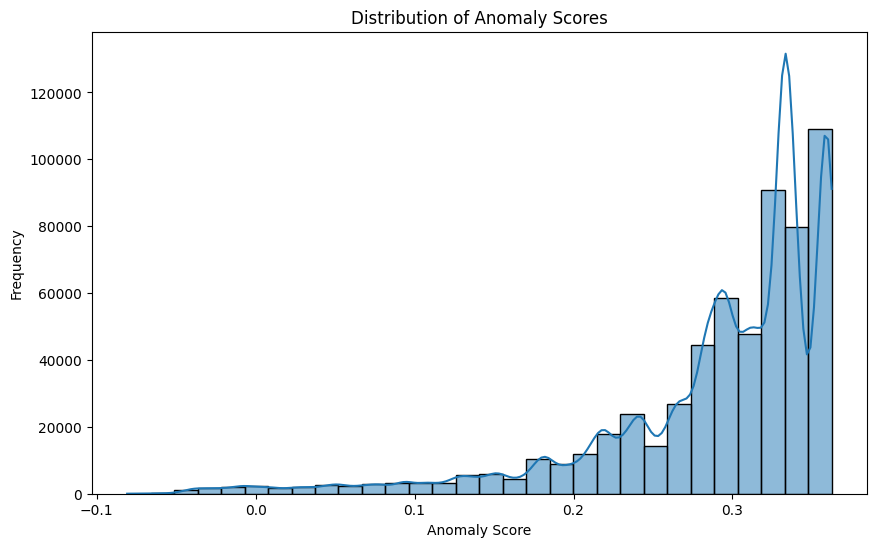

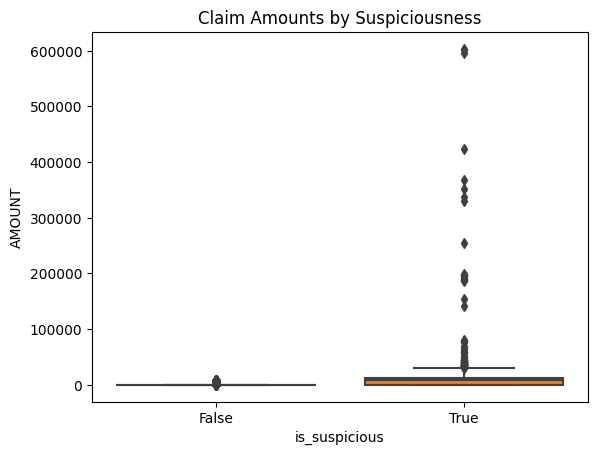

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'merged_df' is already loaded with relevant features

# Select features for anomaly detection
features2 = merged_df[['AMOUNT', 'DAYS_SINCE_LAST_CLAIM', 'NUM_CLAIMS_PER_PROVIDER']]
#features2.fillna(0, inplace=True)  # handle missing values

# Train Isolation Forest
clf2 = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
merged_df['anomaly_score'] = clf.fit_predict(features2)
merged_df['anomaly_score'] = clf.decision_function(features2)

# Visualize anomaly scores
plt.figure(figsize=(10,6))
sns.histplot(merged_df['anomaly_score'], bins=30, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

# Flag high anomaly scores
threshold = np.percentile(merged_df['anomaly_score'], 2)  # bottom 2% as anomalies
merged_df['is_suspicious'] = merged_df['anomaly_score'] < threshold

# Plot suspicious vs. normal claims
sns.boxplot(x='is_suspicious', y='AMOUNT', data=merged_df)
plt.title('Claim Amounts by Suspiciousness')
plt.show()

> **INFO: What is Feature Importance?**
Feature importance in machine learning refers to techniques that help identify which features (input variables) contribute most to the predictive power of a model. 
It provides insights into which factors are most influential in making predictions, aiding in model interpretability and understanding.

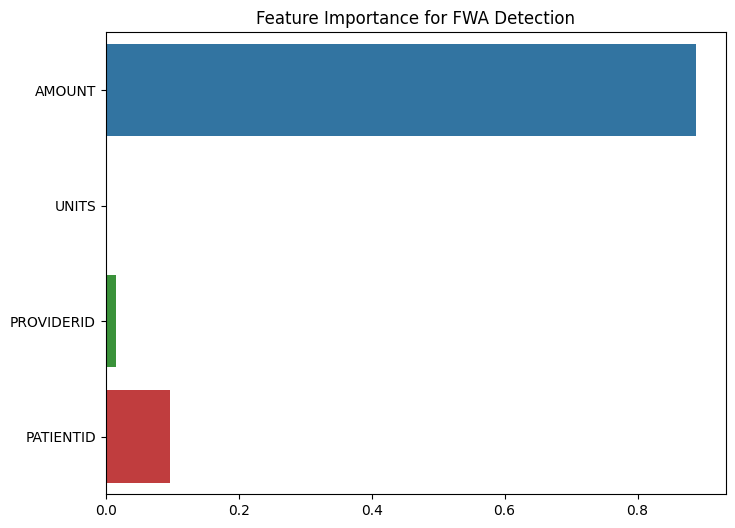

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Prepare labeled data (suspicious vs. normal)
X = features
y = merged_df['is_suspicious'].astype(int)  # 1: suspicious, 0: normal

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Plot feature importance
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance for FWA Detection')
plt.show()

### 1. Model Performance Evaluation

> **Objective:** Assess how well the model distinguishes suspicious from normal claims.

> **Plot:** ROC Curve and AUC score

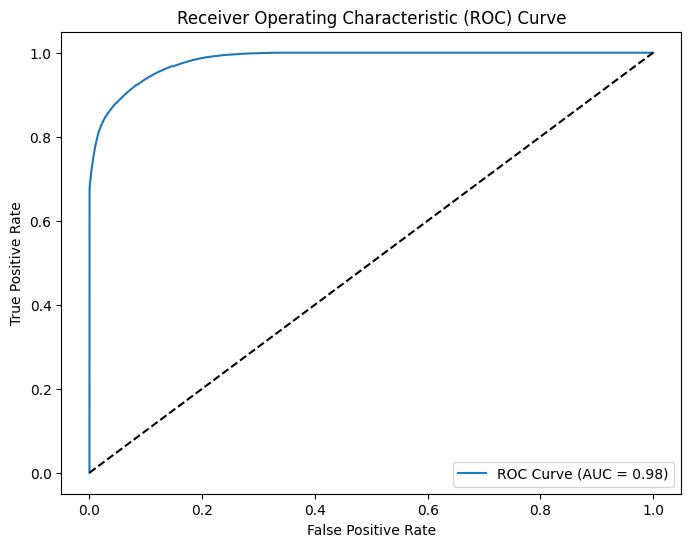

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities
y_pred_proba = rf.predict_proba(X)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
auc_score = roc_auc_score(y, y_pred_proba)

# Plot ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### 2. Identify Top Suspicious Claims

> **Objective:** Highlight claims with the highest anomaly scores.

> **Plot:** Scatter plot of anomaly scores vs. claim features

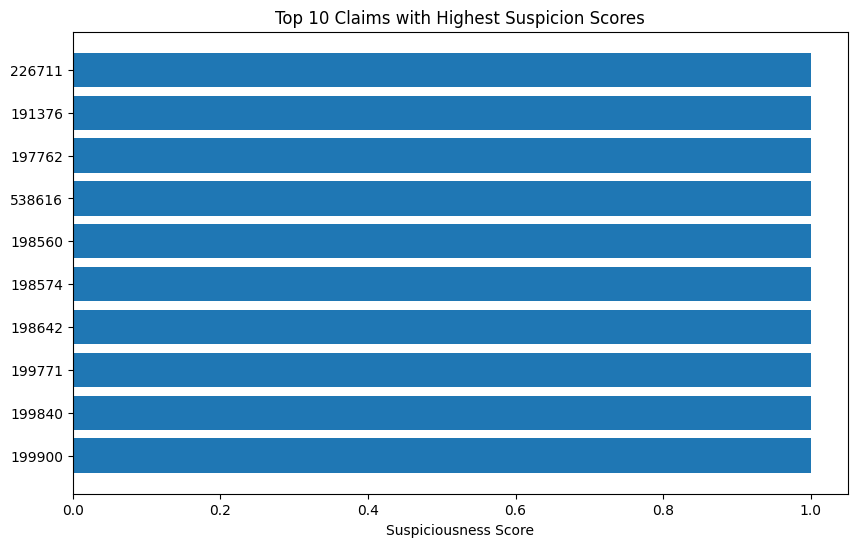

In [12]:
import numpy as np

# Assuming you have anomaly scores from Isolation Forest
# For demonstration, using Random Forest feature importances as proxy (you may replace with actual anomaly scores)
anomaly_scores = rf.predict_proba(X)[:, 1]

# Plot top 10 claims with highest scores
top_indices = np.argsort(anomaly_scores)[-10:]
plt.figure(figsize=(10,6))
plt.barh(range(10), anomaly_scores[top_indices], tick_label=top_indices)
plt.xlabel('Suspiciousness Score')
plt.title('Top 10 Claims with Highest Suspicion Scores')
plt.show()

### 3. Feature Impact Visualization (Partial Dependence Plots)
> **Objective:** Understand how individual features affect the suspicion score.

> **Plot:** Partial dependence plots for key features

In [ ]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming you already have this
importances = rf.feature_importances_

# Get indices of top 3 features
indices_top_features = np.argsort(importances)[-3:]
# Get feature names for these top features
important_features = [X.columns[i] for i in indices_top_features]
print("Top features:", important_features)

# Plot partial dependence for the top important features
features_to_plot = important_features  # list of feature names

PartialDependenceDisplay.from_estimator(rf, X, features=features_to_plot)
plt.suptitle('Partial Dependence of Top Features')
plt.show()


Top features: ['PROVIDERID', 'PATIENTID', 'AMOUNT']
